In [3]:
import sys
sys.path.append('..')
import emlddmm
import numpy as np
import matplotlib.pyplot as plt
from os import sep
from os.path import isdir,join
import json
from glob import glob
from warnings import warn
from difflib import SequenceMatcher

# functionality

We need to input a point in any space (3D or 2D), and output a point in any space (3D or 2D).

For 2D we should be able to go back and forth between pixels and microns.

In [4]:
# each slice will have a vtk displacement field
# this got moved to json
# the json also includes high resolution info
# Hua140/GDM_2022_format_registration_output/registered_histology/atlas_to_registered_histology/transforms_json/'
# where can we get this high resolution information?
# there is a json with fields nx_highres, dx_highres, ox_highres
# for each slice
# 
# how can I get that information for input space?
# 
# there is another folder called atlas_to_histology/ (without the registered)
# there will be a vtk json
# and it will also contain nx_highres, dx_highres, ox_highres for the INPUT histology
#
#

# for high res info I'll do the following
# 1. check if info is in input arguments
# 2. check if any information is in the registration data structure (directory or zip file) in a "transforms_json" file
# 3. do some kind of a database query
# 4. make assumption about the structure, and print a warning


In [5]:
# IGNORE THIS CELL IT IS NOT BEING USED
class sloppy_list(list):
    '''A list class where we overload the in operator'''
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def __contains__(self,x):
        status = super().__contains__(x)
        if status:
            return status
        
        print(f'{x} is not in {self}, checking case changes')
        xl = x.lower()
        for a in self:
            if xl == a.lower():
                print('matched')
                return True
        print(f'{x} is not in {self} after ignoring case, checking partial matches')
        xl = x.lower()
        edit_distances = []
        for a in self:
            al = a.lower()
            edits = [e for e in SequenceMatcher(a=a,b=xl).get_opcodes() if e[0] != 'equal']
            print(edits)
            edit_distances.append(len(edits))
        
        if min(edit_distances) == 0 or min(edit_distances) == 1:
            print(f'min edit distance is {min(edit_distances)} returning true')
            return True
        if min(edit_distances) < 0.1*len(x):
            print('min edit distance is les than 10% of length, returning true')
            return True
        
        print('could not match, returning False')
        return False
        
        
    
    def __repr__(self):
        return 'sloppy list: ' + super().__repr__()

In [6]:
a = sloppy_list(['a','b'])
('As' in a) 

As is not in sloppy list: ['a', 'b'], checking case changes
As is not in sloppy list: ['a', 'b'] after ignoring case, checking partial matches
[('insert', 1, 1, 1, 2)]
[('replace', 0, 1, 0, 2)]
min edit distance is 1 returning true


True

In [7]:
# TODO use this function
# this will ultimately go into the other python file
def pixels_to_microns(x,y,dx,ox):
    '''
    TODO: this is in progress, right now it only supports 2D.  We are not using it currently
    '''
    return x*dx[0] + ox[0], y*dx[1] + ox[1]

In [17]:
# our point mapper code is in a py file here
from point_mapper import point_mapper

# First example, mapping from input space to registered space

In [10]:
# we will need to input a list of x,y point
# and some information about the z location, which could be the name of the slice
input_points_xy = ([35.0,45.0,60.0],[40.0,37.0,35.0])
z = 'PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021'

for this example, we use the following input image file
../examples/mouse_serial_section_example/NisslDown/PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021.jpg


Text(0.5, 1.0, 'image and points with units of pixels')

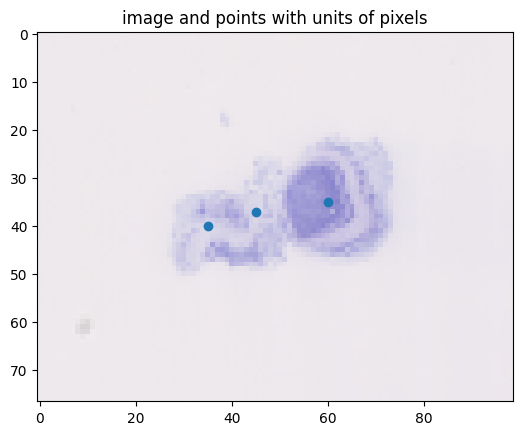

In [11]:
# let's work though this
# first find the image that corresponds to z above
input_image_file = glob('../examples/mouse_serial_section_example/NisslDown/' + z + '*.jpg')[0]
print('for this example, we use the following input image file')
print(input_image_file)
J = plt.imread(input_image_file)
fig,ax = plt.subplots()
ax.imshow(J)
# we can draw our points here because this is units of pixels
ax.scatter(input_points_xy[0], input_points_xy[1])
ax.set_title('image and points with units of pixels')
# NOTE, in this example 
# we have placed some landmark points in the middle of the two hemispheres


[58.88 58.88 20.  ] [-2885.1200000000003, -2237.44, -6270.0]
[-824.32 -235.52  647.68] [ 117.76  -58.88 -176.64]


Text(0.5, 1.0, 'image and points with units of microns')

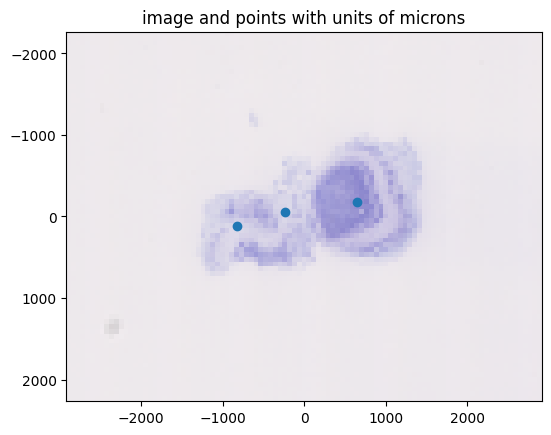

In [12]:
# now we need to find out about the geometry of the INPUT IMAGE file
# we always need origin and pixel size
# 
# 
# in this case the image is in our "standard input structure for command line" so it has a sidecar json file
# in GENERAL, you can get origin and pixel spacing however you want
# NOTE, for input space we don't have any information about where the origin is relative to anatomy
# because we haven't looked at the image and haven't registered.
# but to do mapping we need to assign an xyz coordinate to every pixel
# our convention is that 0,0,0 is the middle of our volume of input slices.
# so the origin is in the center of every 2D slice
with open(input_image_file.replace('.jpg','.json')) as f:
    json_data = json.load( f )
    
dx_input = np.diag(json_data['SpaceDirections'][1:])
ox_input = json_data['SpaceOrigin']
print(dx_input, ox_input)

# what if we did not have this information?
# we would look up the size of the jp2 file: nx, ny
# we would look up the resolution of the jp2 file: dx, dy (probably 0.46,0.46, or 0.46*32, 0.46*32)
# then we would find the pixel locations as
# x = np.arange(nx)*dx
# x = x - np.mean(x)
# y = np.arange(ny)*dy
# y = y - np.mean(y)
# ox = x[0]
# oy = y[0]
nx_input = J.shape[1],J.shape[0]

x_input = ox_input[0] + np.arange(nx_input[0])*dx_input[0]
y_input = ox_input[1] + np.arange(nx_input[1])*dx_input[1]

# for drawing figures in the right spot in python, we need an extent
extent_input = (x_input[0]-dx_input[0]/2, x_input[-1]+dx_input[0]/2, y_input[-1]+dx_input[1]/2, y_input[0]-dx_input[1]/2)
fig,ax = plt.subplots()
ax.imshow(J,extent=extent_input)

# let me now scale the points into microns, and draw them on here
x_microns =  ox_input[0] + np.array(input_points_xy[0])*dx_input[0]
y_microns =  ox_input[1] + np.array(input_points_xy[1])*dx_input[1]
print(x_microns, y_microns)
ax.scatter(x_microns,y_microns)
ax.set_title('image and points with units of microns')

In [13]:
# example, input points map from target_registered to target
# note, mouse_serial_setion_example is on github
# note file paths ca neither be relative or absolute (absolute should start with a "/")
out = point_mapper(
    '../examples/mouse_serial_section_example/output/', # registration data (directory of registration outputs, OR zip file with same info or a subset, OR something in memory)
    input_points_xy[0], input_points_xy[1], # x y, can be single numbers or lists
    z=z, # can be a filename or a coordinate
    from_space='Target',to_space='Target_registered', # list spaces to map between
    from_units='pixels',
    to_units='pixels',
    from_ox=[-2885.1200000000003, -2237.44], from_dx=[58.88,58.88],
    to_ox=[-5829.1201171875, -4386.56005859375], to_dx=[58.8798828125, 58.8798828125],
)
# Target usually equals "Nissl" which is an input space.
# but you can use any name you want
print(out)

registration data is a directory
printing x
[35. 45. 60.]
printing y
[40. 37. 35.]
printing z
found a filename for z PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
From space is Target
To space is Target_registered
identified spaces ['Target_registered', 'Atlas', 'Target']
converting from pixels to microns in input space
before
[35. 45. 60.] [40. 37. 35.] PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
after
[-824.32 -235.52  647.68] [ 117.76  -58.88 -176.64] PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
Found transform dir ../examples/mouse_serial_section_example/output/Target/Target_registered_to_Target/transforms
This is a 2D transform
Matched to the transformation file ../examples/mouse_serial_section_example/output/Target/Target_registered_to_Target/transforms/Target_PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021_to_Target_registered_PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021_matrix.txt
[[-9.96619701e-01 -8.21528286e-02  1.59674664e+01]
 [ 8.215282

../point_mapper.py:154: UserWarning: We need to specify spacing and origin in the from space
  warn(f'We need to specify spacing and origin in the from space')


Text(0.5, 1.0, 'In units of microns the points line up')

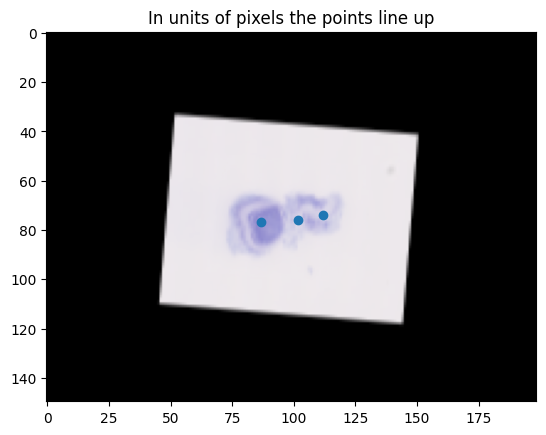

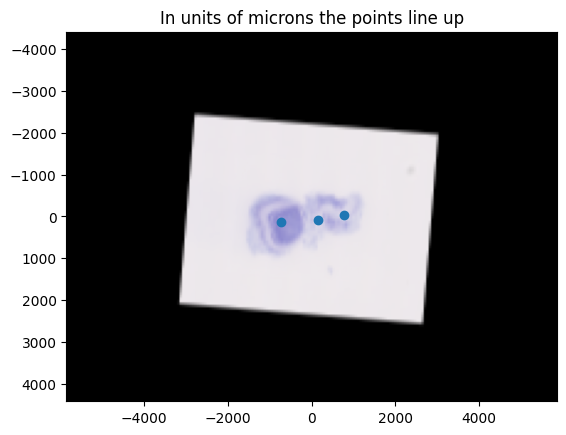

In [15]:
# now let's load the "registered space image"
# in our output this is a vtk file
# here this assumes it is in pixel space
registered_image_file = glob('../examples/mouse_serial_section_example/output/Target_registered/Target_to_Target_registered/images/*' + z + '*.vtk')[0]
xregistered,Jregistered,_,_ = emlddmm.read_data(registered_image_file)
# change vtk conventions to our above conventions
J_registered = Jregistered[:,0].transpose(1,2,0)
x_registered = xregistered[-1]
y_registered = xregistered[-2]
dx_registered = (x_registered[1] - x_registered[0], y_registered[1] - y_registered[0])
nx_registered = J_registered.shape[1],J_registered.shape[0]
ox_registered = x_registered[0], y_registered[0]
extent_registered = (x_registered[0]-dx_registered[0]/2, x_registered[-1]+dx_registered[0]/2, y_registered[-1]+dx_registered[1]/2, y_registered[0]-dx_registered[1]/2)
fig,ax = plt.subplots()
ax.imshow(J_registered)
ax.scatter(out[0],out[1])
ax.set_title('In units of pixels the points line up')

# now let's put it back in units of microns
fig,ax = plt.subplots()
ax.imshow(J_registered,extent=extent_registered)
ax.scatter(out[0]*dx_registered[0] + ox_registered[0],out[1]*dx_registered[1] + ox_registered[1])
ax.set_title('In units of microns the points line up')


In [16]:
raise Exception('Stop here, nothing below has been validated')

Exception: Stop here, nothing below has been validated

# Second example, mapping from input space to atlas

In [ ]:
# example, input points 11 map from target_registered to target
point_mapper('examples/mouse_serial_section_example/output/',
             [1.0,2.0],[1.0,5.0], # xy
             z='PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021', # look up from filename
             from_space='Target',to_space='Atlas',
             from_units='microns') # note most important use case will be pixels

In [ ]:
# example, input points 11 map from target_registered to target
transformed_points = point_mapper(
    'examples/mouse_serial_section_example/output/',
    [1.0,2.0],[1.0,5.0], # xy           
    [0.0,1.0],
    from_space='Atlas',to_space='Target_registered'
)

In [ ]:
# example, input points 11 map from target_registered to target
point_mapper('examples/mouse_serial_section_example/output/',
             [1.0,2.0],[1.0,5.0], # xy
             z='PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021', # look up from filename
             from_space='Target',to_space='Atlas',
             from_units='pixels') # note most important use case will be pixels

In [ ]:
# where can we get high resolutoin point information?
# it can be an optional input argument
# NOTE: 
# 